## Small Dataset Full-Image Species Exploration 

In this notebook, we explore a portion of Haiti Tree Project (THTP) captures verified by Cam.

### Dependencies

In [1]:
import torch
import numpy as np
import pandas as pd
import os
import sklearn
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import urllib
import time
from PIL import Image

from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split

import torchvision.models as models
from torchvision.io import read_image
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader

torch.backends.cudnn.benchmark = True

### Data Retrieval
 
 
For now, download each image/label pair Cam has specified ([Github link](https://github.com/Greenstand/Tree_Species/tree/master/training)).

In [2]:
datadir = "/home/ec2-user/SageMaker/treetracker-machine-learning/sample_datasets/Haiti/cam_training.psv"
baseurl = "https://treetracker-production-images.s3.eu-central-1.amazonaws.com/"
assert os.path.exists(datadir)
data = pd.read_csv(datadir, sep="|", header=None)
data.columns = ["class", "imname"]
data["url"] = baseurl + data["imname"]
data.head(5)

,class,imname,url
0,ACACAURI,2020.11.29.12.18.36_18.285143729299307_-73.564...,https://treetracker-production-images.s3.eu-ce...
1,ACACAURI,2020.11.29.12.18.59_18.285102993249893_-73.564...,https://treetracker-production-images.s3.eu-ce...
2,ACACAURI,2020.11.29.12.47.34_18.290133895352483_-73.557...,https://treetracker-production-images.s3.eu-ce...
3,ACACAURI,2020.11.29.12.50.51_18.29083981923759_-73.5582...,https://treetracker-production-images.s3.eu-ce...
4,ACACAURI,2020.11.29.13.29.55_18.29298411961645_-73.5581...,https://treetracker-production-images.s3.eu-ce...


In [3]:
savepath = "/home/ec2-user/SageMaker/treetracker-machine-learning/sample_datasets/Haiti/"
for species in data["class"].unique():
    if not os.path.exists(os.path.join(savepath, species)):
        os.makedirs(os.path.join(savepath, species))
image_saver = lambda df: urllib.request.urlretrieve(df["url"], os.path.join(savepath, df["class"], df["imname"]))
data.apply(image_saver, axis=1)


0      (/home/ec2-user/SageMaker/treetracker-machine-...
1      (/home/ec2-user/SageMaker/treetracker-machine-...
2      (/home/ec2-user/SageMaker/treetracker-machine-...
3      (/home/ec2-user/SageMaker/treetracker-machine-...
4      (/home/ec2-user/SageMaker/treetracker-machine-...
                             ...                        
383    (/home/ec2-user/SageMaker/treetracker-machine-...
384    (/home/ec2-user/SageMaker/treetracker-machine-...
385    (/home/ec2-user/SageMaker/treetracker-machine-...
386    (/home/ec2-user/SageMaker/treetracker-machine-...
387    (/home/ec2-user/SageMaker/treetracker-machine-...
Length: 388, dtype: object

388  total samples
Class breakdown
          imname  url
class                
ACACAURI     111  111
ANACOCCI      53   53
CATALONG      75   75
MANGINDI     149  149
4  classes found


Text(0.5, 1.0, 'Count per class')

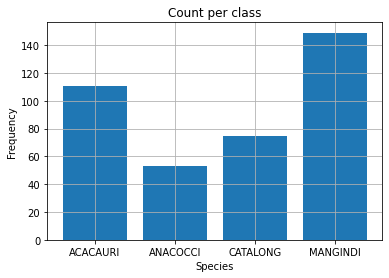

In [4]:
print (data.shape[0], " total samples")
print ("Class breakdown")
count_by_class = data.groupby("class").aggregate("count")
baseline_acc = np.max
print (dict(zip(count_by_class.index, count_by_class.values[:, 0])))
num_classes = data["class"].unique().shape[0]
print (num_classes, " classes found")
plt.bar(count_by_class.index, count_by_class["imname"])
plt.grid()
plt.xlabel("Species")
plt.ylabel("Frequency")
plt.title("Count per class")

In [5]:
arrs = []
labels = []
for species in data["class"].unique():
    for img in os.listdir(os.path.join(savepath, species)):
        if os.path.splitext(os.path.join(savepath, species, img))[1].lower() in [".jpg", ".png"]:
            arrs.append(Image.open(os.path.join(savepath, species, img)).resize((224, 224)))
            labels.append(species)
            


In [6]:
X = np.vstack([np.asarray(img).flatten() for img in arrs])
X_embedded = TSNE(n_components=2, perplexity=30.0, learning_rate=25.0, n_iter=10000).fit_transform(X)

In [7]:
tsne_result = pd.DataFrame(X_embedded)
tsne_result["class"] = labels
tsne_result.columns = ["x0", "x1", "class"]
colors = np.linspace(0, 1, len(data["class"].unique()))
colordict = dict(zip(data["class"].unique(), colors))  
tsne_result["Color"] = tsne_result["class"].apply(lambda x: colordict[x])

In [8]:
print (tsne_result.head(5))

         x0        x1     class  Color
0  0.755226 -0.992364  ACACAURI    0.0
1  1.142595  2.852109  ACACAURI    0.0
2 -0.415559 -0.116691  ACACAURI    0.0
3 -1.115901  1.229978  ACACAURI    0.0
4  0.513012  0.835333  ACACAURI    0.0


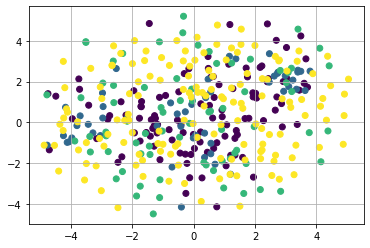

In [9]:
plt.grid()
plt.scatter(tsne_result["x0"], tsne_result["x1"], c=tsne_result["Color"])


{'ACACAURI': 111, 'ANACOCCI': 53, 'CATALONG': 75, 'MANGINDI': 149}


In [51]:

def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False
            

transform = T.Compose([T.Resize(512), T.CenterCrop(299), T.ToTensor()])

inception = models.inception_v3(pretrained=True)
set_parameter_requires_grad(inception, feature_extracting=True)
num_ftrs = inception.AuxLogits.fc.in_features
inception.AuxLogits.fc = torch.nn.Linear(num_ftrs, num_classes)
# Handle the primary net
num_ftrs = inception.fc.in_features
inception.fc = torch.nn.Linear(num_ftrs,num_classes)

params_to_update = []
for name, param in inception.named_parameters():
    if param.requires_grad:
        params_to_update.append(param)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print ("Device: ", device)
# class_weights = np.array([3/6, 6/6, 4/6, 2/6]) # this is 1/frequency sorry this is convoluted :D
class_weights = np.ones(4)
class_weights = class_weights / np.sum(class_weights)
criterion = torch.nn.CrossEntropyLoss(reduction="mean", weight=torch.Tensor(class_weights)).cuda()
inception = inception.to(device)
optimizer = torch.optim.Adam(params_to_update, lr=0.001)

Device:  cuda:0


In [11]:
# this cell doesn't work but doesn't matter right now :D 
preds = [inception(transform(img)[None, ...].to(device)).detach().numpy() for img in arrs]

ValueError: Expected more than 1 value per channel when training, got input size torch.Size([1, 768, 1, 1])

In [12]:
print (data.head(5))

      class                                             imname  \
0  ACACAURI  2020.11.29.12.18.36_18.285143729299307_-73.564...   
1  ACACAURI  2020.11.29.12.18.59_18.285102993249893_-73.564...   
2  ACACAURI  2020.11.29.12.47.34_18.290133895352483_-73.557...   
3  ACACAURI  2020.11.29.12.50.51_18.29083981923759_-73.5582...   
4  ACACAURI  2020.11.29.13.29.55_18.29298411961645_-73.5581...   

                                                 url  
0  https://treetracker-production-images.s3.eu-ce...  
1  https://treetracker-production-images.s3.eu-ce...  
2  https://treetracker-production-images.s3.eu-ce...  
3  https://treetracker-production-images.s3.eu-ce...  
4  https://treetracker-production-images.s3.eu-ce...  


In [45]:
class HaitiDataset(torch.utils.data.Dataset):
    def __init__(self, df, loadpath, transform, encoding):
        '''
        A dataset with image names, classes, and a provided loading path to load images from
        '''
        self.loadpath = loadpath
        self.data = df
        self.n_classes = self.data["class"].unique().shape[0]
        self.transform = transform
        self.numerical_encoding = dict(zip(list(self.data["class"].unique()), list(range(self.n_classes))))
    
    def __len__(self):
        return self.data.shape[0]
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.loadpath, self.data.iloc[idx, :]["class"], self.data.iloc[idx, :]["imname"])
        label = self.data.iloc[idx, :]["class"]
        img = self.transform(Image.open(img_path))
        label = self.numerical_encoding[label]
        return img, label
        
        

In [46]:
val_split = 0.5
idxs = np.arange(data.shape[0])
np.random.shuffle(idxs)

tr_idxs = idxs[:int (val_split * data.shape[0]), ...]
val_idxs = idxs[int (val_split * data.shape[0]):, ...]

tr_dataset = HaitiDataset(data.iloc[tr_idxs, :], savepath, transform, None)
val_dataset = HaitiDataset(data.iloc[val_idxs, :], savepath, transform, None)

tr_dataloader = DataLoader(tr_dataset, batch_size=4, shuffle=True, num_workers=2, pin_memory=True)
val_dataloader = DataLoader(val_dataset, batch_size=val_idxs.shape[0], shuffle=True, num_workers=2, pin_memory=True)

num_epochs = 20

In [52]:
for epoch in range(num_epochs):
    running_loss = 0
    start = time.time()
    tr_acc_sum = 0
    tr_samples = 0
    n_tr_batches = 0
    n_val_batches = 0
    for batch_x, batch_y in tr_dataloader:
        n_tr_batches += 1
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)
        optimizer.zero_grad()
        output = inception.forward(batch_x)
        loss = criterion(output.logits, batch_y)
        loss.backward()
        optimizer.step()
        # print statistics
        running_loss += loss.item()
        tr_acc_sum += torch.sum(torch.argmax(output.logits, dim=1) == batch_y)
        tr_samples += batch_y.size()[0]
    with torch.no_grad():
        val_samples = 0
        running_val_loss = 0
        val_acc_sum = 0
        for val_x, val_y in val_dataloader:
            n_val_batches += 1
            val_x = val_x.to(device)
            val_y = val_y.to(device)
            val_output = inception.forward(val_x)
            val_loss = criterion(val_output.logits, val_y)
            running_val_loss += val_loss.item()
            val_acc_sum += torch.sum(torch.argmax(val_output.logits, dim=1) == val_y) # wrote this way just in case there's batched validation
            val_samples += val_y.size()[0]
    print ("Epoch %d finished in %f seconds"%(epoch + 1, time.time() - start))
    print ("Training/Validation Loss: %f/ %f"%(running_loss / n_tr_batches, val_loss / n_val_batches))
    print ("Training/Validation Accuracy (percent): %f /%f"%(100 * tr_acc_sum / tr_samples, 100 * val_acc_sum / val_samples))
    print ("=" * 40)
print ("Finished training")

Epoch 1 finished in 11.903148 seconds
Training/Validation Loss: 1.315917/ 1.722525
Training/Validation Accuracy (percent): 40.206184 /19.587627
Epoch 2 finished in 12.350956 seconds
Training/Validation Loss: 1.112887/ 2.025392
Training/Validation Accuracy (percent): 47.938145 /22.680412
Epoch 3 finished in 12.101460 seconds
Training/Validation Loss: 0.972952/ 2.062119
Training/Validation Accuracy (percent): 57.216492 /10.309278
Epoch 4 finished in 12.038043 seconds
Training/Validation Loss: 0.919268/ 2.432805
Training/Validation Accuracy (percent): 62.886597 /15.979381
Epoch 5 finished in 11.821829 seconds
Training/Validation Loss: 0.816380/ 2.594396
Training/Validation Accuracy (percent): 67.525772 /10.824742
Epoch 6 finished in 12.033550 seconds
Training/Validation Loss: 0.637707/ 2.762542
Training/Validation Accuracy (percent): 76.804123 /11.340206
Epoch 7 finished in 12.100375 seconds
Training/Validation Loss: 0.830264/ 2.864535
Training/Validation Accuracy (percent): 68.556702 /12